### **Introduction**

The rapid advancement of multimodal AI models, particularly those that bridge vision and language, has unlocked powerful new capabilities in information retrieval, content generation, and human-AI interaction. Among these, CLIP (Contrastive Language–Image Pretraining) has emerged as a state-of-the-art model capable of aligning images and text in a shared semantic space, enabling zero-shot classification, cross-modal retrieval, and rich semantic understanding without task-specific fine-tuning. This has spurred widespread adoption across academic, industrial, and open-source communities. However, as these models grow in complexity and are deployed at scale, two critical challenges emerge: *interpretability* and *sustainability*.

Despite their impressive performance, models like CLIP operate largely as black boxes, making it difficult to understand how and why a particular image-text match is made. This lack of interpretability poses serious concerns for trust, transparency, and accountability, especially in high-stakes domains such as healthcare, legal reasoning, and surveillance. To build confidence in multimodal AI systems, it is crucial to develop tools that not only perform well but also explain their behavior in a human-understandable way. In this work, we adopt recent gradient-based transformer interpretability methods to produce fine-grained relevance maps over both text and image domains, shedding light on the internal mechanisms of CLIP's retrieval process.

In parallel, another dimension that has received growing attention is the *environmental cost* of AI. The carbon footprint of training and deploying large-scale models is increasingly scrutinized in light of global efforts toward sustainability and responsible innovation. While much attention has been paid to the emissions from training massive foundation models, less focus has been given to the inference-time emissions of real-world AI applications. Yet, inference workloads, particularly in retrieval systems used repeatedly at scale, can contribute significantly to operational emissions. Understanding the energy and carbon cost of inference at varying scales and workloads is essential for developing greener AI systems.

In this project, we bring together these two perspectives, interpretability and sustainability, through the lens of a practical multimodal retrieval task using CLIP. Specifically, we:

1. Build an interpretable image-to-text retrieval pipeline based on the Flickr8k dataset, applying transformer-based relevance attribution to visualize how CLIP maps semantic information across modalities.
2. Track carbon emissions and runtime performance using [CodeCarbon](https://mlco2.github.io/codecarbon/), evaluating how these metrics scale with dataset size during both encoding and retrieval phases.
3. Conduct controlled experiments to explore the trade-offs between model performance, transparency, and environmental cost.

By combining interpretability and emissions analysis in a single framework, we aim to offer a more holistic view of what it means to deploy responsible multimodal AI. We envision this work as a step toward tools that not only perform well but also *explain themselves* and do so *efficiently*. Our methodology and findings may inform future research in energy-aware model deployment, transparent retrieval systems, and low-impact AI pipelines.

In [1]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

# Install required packages
!pip install -q ftfy regex tqdm codecarbon einops captum pandas numpy
!pip install git+https://github.com/openai/CLIP.git

# Download Flickr8k dataset
!wget -q "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
!unzip -q flickr8k.zip -d ./flickr8k
!rm flickr8k.zip

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1477 (delta 90), reused 66 (delta 66), pack-reused 1348 (from 1)
Receiving objects: 100% (1477/1477), 29.01 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (575/575), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.4/576.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 

#Please restart runtime after pip installs!

In [1]:
import os
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms
from tqdm import tqdm
from codecarbon import EmissionsTracker

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)


In [2]:
captions_path = "./flickr8k/captions.txt"
df = pd.read_csv(captions_path)
image_dir = "./flickr8k/Images"
captions = df.groupby('image')['caption'].apply(list).to_dict()
image_list = list(captions.keys())

In [3]:
def load_and_encode_subset(subset_size=100):
    images = []
    filenames = []
    for img_name in tqdm(image_list[:subset_size]):
        path = os.path.join(image_dir, img_name)
        try:
            img = preprocess(Image.open(path).convert("RGB"))
            images.append(img)
            filenames.append(img_name)
        except:
            continue
    images = torch.stack(images).to(device)
    with torch.no_grad():
      image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return filenames, image_features

def retrieve(text_query, image_features, filenames, top_k=5):
    with torch.no_grad():
        text_tokens = clip.tokenize([text_query]).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).squeeze()
        top_indices = similarity.topk(top_k).indices

    return [(filenames[i], similarity[i].item()) for i in top_indices]

In [4]:
# Run a sample query

filenames, image_features = load_and_encode_subset(subset_size=500)
query = "a child eating ice cream"
results = retrieve(query, image_features, filenames)

100%|██████████| 500/500 [00:06<00:00, 75.33it/s] 


### Retrival Example

1224851143_33bcdd299c.jpg | Score: 31.97


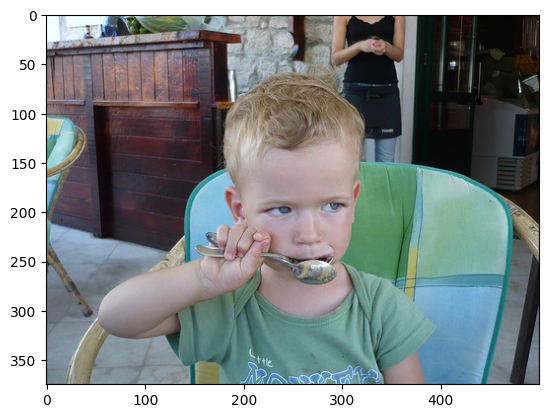

1459032057_97e73ed6ab.jpg | Score: 31.17


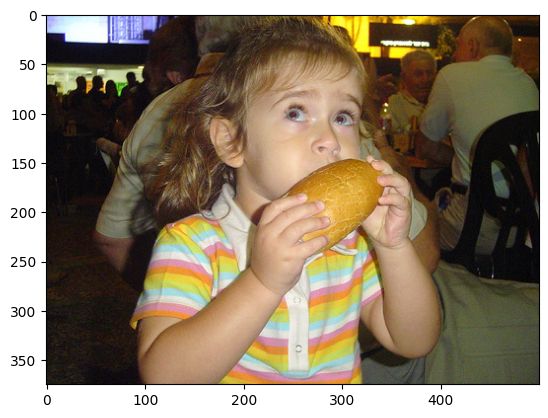

1301140633_046e4e8010.jpg | Score: 29.61


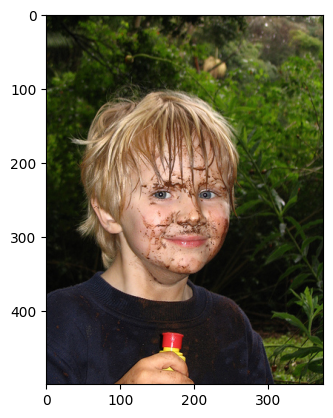

1034276567_49bb87c51c.jpg | Score: 28.41


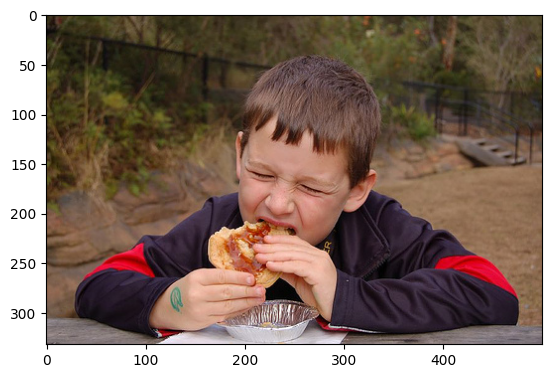

1015118661_980735411b.jpg | Score: 28.09


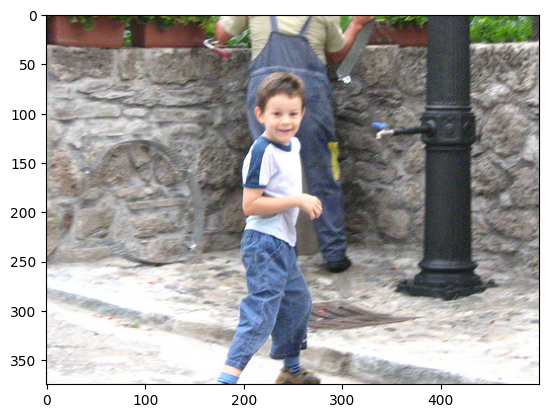

In [9]:
for fname, score in results:
    print(f"{fname} | Score: {score:.2f}")
    img_path = os.path.join(image_dir, fname)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()

### Emisson Analysis

In [10]:
subset_sizes = [100, 250, 500, 1000, 2000, 5000]
query = "a dog running"
top_k = 5

retrieval_outputs = {}

for size in subset_sizes:

    print(f"\n--- Evaluating subset size: {size} ---")

    tracker = EmissionsTracker(project_name=f"CLIP Flickr8k Encode ({size})")
    tracker.start()

    filenames, image_features = load_and_encode_subset(subset_size=size)

    emissions = tracker.stop()
    print(f"CO₂ emissions for {size} images: {emissions:.4f} kg")

    tracker = EmissionsTracker(project_name=f"CLIP Flickr8k Retrival ({size})")
    tracker.start()

    _ = retrieve(query, image_features, filenames, top_k=top_k)

    emissions = tracker.stop()
    print(f"CO₂ emissions for {size} images: {emissions:.4f} kg")
    torch.cuda.empty_cache()

[codecarbon WARNING @ 12:23:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:23:11] [setup] RAM Tracking...
[codecarbon INFO @ 12:23:11] [setup] CPU Tracking...



--- Evaluating subset size: 100 ---


[codecarbon WARNING @ 12:23:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:12] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:12] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:12]   Platform sys

CO₂ emissions for 100 images: 0.0000 kg


[codecarbon WARNING @ 12:23:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:14] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:14] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:14] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:14]   Platform sys

CO₂ emissions for 100 images: 0.0000 kg

--- Evaluating subset size: 250 ---


[codecarbon WARNING @ 12:23:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:16] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:16] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:16]   Platform sys

CO₂ emissions for 250 images: 0.0000 kg


[codecarbon WARNING @ 12:23:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:19] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:19] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:19] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:19] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:19]   Platform sys

CO₂ emissions for 250 images: 0.0000 kg

--- Evaluating subset size: 500 ---


[codecarbon WARNING @ 12:23:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:20] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:20] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:20]   Platform sys

CO₂ emissions for 500 images: 0.0000 kg


[codecarbon WARNING @ 12:23:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:25] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:25] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:25] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:25] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:25]   Platform sys

CO₂ emissions for 500 images: 0.0000 kg

--- Evaluating subset size: 1000 ---


[codecarbon WARNING @ 12:23:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:27] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:27] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:27]   Platform sys

CO₂ emissions for 1000 images: 0.0001 kg


[codecarbon WARNING @ 12:23:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:36] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:36] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:36] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:36]   Platform sys

CO₂ emissions for 1000 images: 0.0000 kg

--- Evaluating subset size: 2000 ---


[codecarbon WARNING @ 12:23:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:37] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:37] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:37]   Platform sys

CO₂ emissions for 2000 images: 0.0001 kg


[codecarbon WARNING @ 12:23:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:53] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:53] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:53]   Platform sys

CO₂ emissions for 2000 images: 0.0000 kg

--- Evaluating subset size: 5000 ---


[codecarbon WARNING @ 12:23:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:23:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:23:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:23:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:23:55] [setup] GPU Tracking...
[codecarbon INFO @ 12:23:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:23:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:23:55] >>> Tracker's metadata:
[codecarbon INFO @ 12:23:55]   Platform sys

CO₂ emissions for 5000 images: 0.0003 kg


[codecarbon WARNING @ 12:24:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:24:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:24:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 12:24:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:24:37] [setup] GPU Tracking...
[codecarbon INFO @ 12:24:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:24:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 12:24:37] >>> Tracker's metadata:
[codecarbon INFO @ 12:24:37]   Platform sys

CO₂ emissions for 5000 images: 0.0000 kg


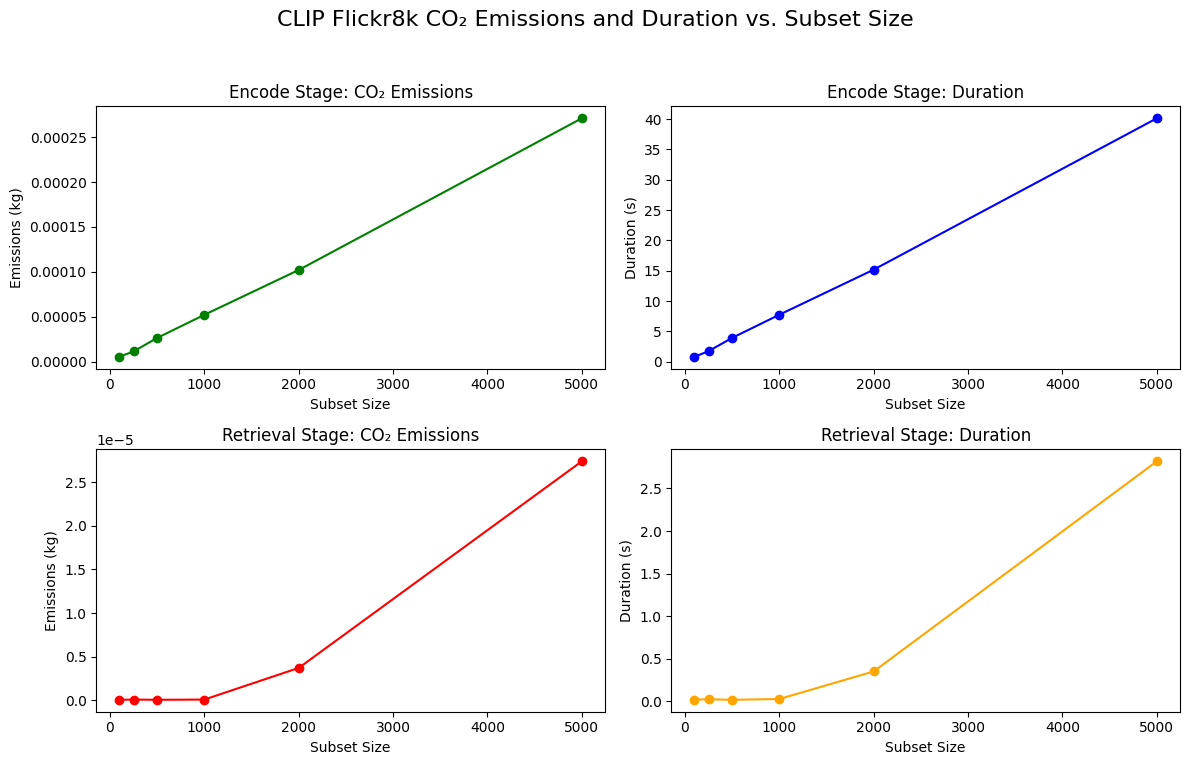

In [16]:
import re

# Load emissions CSV
emissions = pd.read_csv("emissions.csv")

# Extract stage (Encode / Retrieval) and subset size
def parse_project(row):
    match = re.match(r"CLIP Flickr8k (Encode|Retrival) \((\d+)\)", row["project_name"])
    if match:
        stage, size = match.groups()
        return stage.lower(), int(size)
    return None, None

emissions[["stage", "subset_size"]] = emissions.apply(lambda row: pd.Series(parse_project(row)), axis=1)

# Separate encode and retrieval
encode_df = emissions[emissions["stage"] == "encode"].sort_values("subset_size")
retrieval_df = emissions[emissions["stage"] == "retrival"].sort_values("subset_size")

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("CLIP Flickr8k CO₂ Emissions and Duration vs. Subset Size", fontsize=16)

# Encode: Emissions
axs[0, 0].plot(encode_df["subset_size"], encode_df["emissions"], marker='o', color='green')
axs[0, 0].set_title("Encode Stage: CO₂ Emissions")
axs[0, 0].set_xlabel("Subset Size")
axs[0, 0].set_ylabel("Emissions (kg)")

# Encode: Duration
axs[0, 1].plot(encode_df["subset_size"], encode_df["duration"], marker='o', color='blue')
axs[0, 1].set_title("Encode Stage: Duration")
axs[0, 1].set_xlabel("Subset Size")
axs[0, 1].set_ylabel("Duration (s)")

# Retrieval: Emissions
axs[1, 0].plot(retrieval_df["subset_size"], retrieval_df["emissions"], marker='o', color='red')
axs[1, 0].set_title("Retrieval Stage: CO₂ Emissions")
axs[1, 0].set_xlabel("Subset Size")
axs[1, 0].set_ylabel("Emissions (kg)")

# Retrieval: Duration
axs[1, 1].plot(retrieval_df["subset_size"], retrieval_df["duration"], marker='o', color='orange')
axs[1, 1].set_title("Retrieval Stage: Duration")
axs[1, 1].set_xlabel("Subset Size")
axs[1, 1].set_ylabel("Duration (s)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### **Interpretation of Emission and Runtime Visualizations**

The visualization of CO₂ emissions and processing durations across varying subset sizes reveals important insights into the computational behavior of the CLIP-based retrieval pipeline. In particular, we observe that the emissions associated with the **encoding step** scale **approximately linearly** with the subset size. This is expected, as encoding involves independently preprocessing and embedding each image, and the computational cost grows proportionally with the number of images processed.

In contrast, the **retrieval step** exhibits a markedly different trend. Both emissions and runtime during retrieval increase **exponentially** with respect to subset size. This is due to the fact that retrieval requires comparing each query embedding against the entire image embedding set, resulting in a computational complexity that scales with the size of the dataset. As the number of image embeddings grows, the cost of calculating and sorting similarity scores becomes increasingly dominant.

This divergence in scaling behavior has significant implications. While encoding can be amortized and cached, retrieval must be executed per query, and its rising emissions highlight a potential bottleneck for sustainable deployment, especially in large-scale or real-time systems. These findings reinforce the importance of optimizing retrieval strategies (e.g., through approximate search or indexing methods) and designing emissions-aware AI systems that remain efficient as usage scales.

## Visalize Attention

In [17]:
%cd Transformer-MM-Explainability
import CLIP.clip as clip_interp
from captum.attr import visualization
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip_interp.load("ViT-B/32", device=device, jit=False)

/content/Transformer-MM-Explainability


In [18]:
def interpret(image, texts, model, device, start_layer=-1, start_layer_text=-1):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [19]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [20]:
_tokenizer = _Tokenizer()
def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    text_tokens = _tokenizer.encode(text)
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
    visualization.visualize_text(vis_data_records)


In [21]:
captions_path = "../flickr8k/captions.txt"
df = pd.read_csv(captions_path)
image_dir = "../flickr8k/Images"
captions = df.groupby('image')['caption'].apply(list).to_dict()
image_list = list(captions.keys())

In [22]:
def load_and_encode_subset(subset_size=100):
    images = []
    filenames = []
    for img_name in tqdm(image_list[:subset_size]):
        path = os.path.join(image_dir, img_name)
        try:
            img = preprocess(Image.open(path).convert("RGB"))
            images.append(img)
            filenames.append(img_name)
        except:
            continue
    images = torch.stack(images).to(device)
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return filenames, image_features

def retrieve(text_query, image_features, filenames, top_k=5):
    text_tokens = clip_interp.tokenize([text_query]).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).squeeze()
    top_indices = similarity.topk(top_k).indices

    return [(filenames[i], similarity[i].item()) for i in top_indices]

filenames, image_features = load_and_encode_subset(subset_size=500)

100%|██████████| 500/500 [00:03<00:00, 140.97it/s]


In [23]:
# Run a sample query
query = "a child eating ice cream"
results = retrieve(query, image_features, filenames)

1224851143_33bcdd299c.jpg | Score: 31.95


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a child eating ice cream


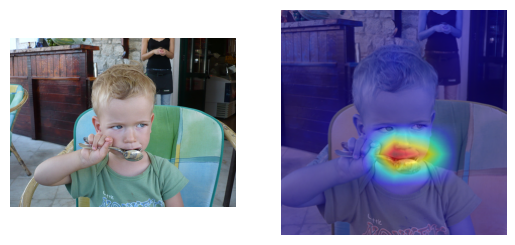

1459032057_97e73ed6ab.jpg | Score: 31.17


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a child eating ice cream


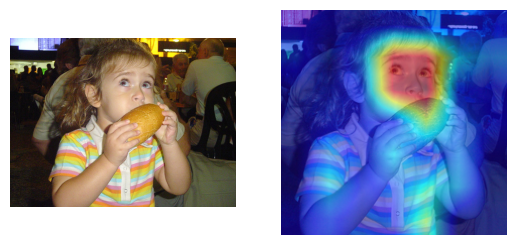

1301140633_046e4e8010.jpg | Score: 29.61


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a child eating ice cream


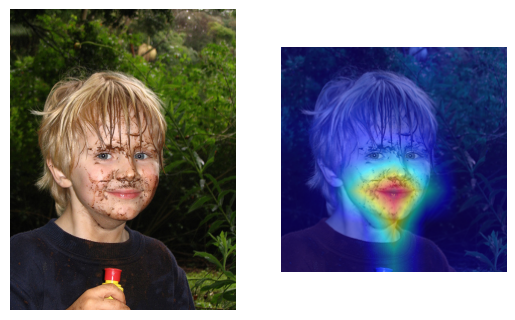

1034276567_49bb87c51c.jpg | Score: 28.42


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a child eating ice cream


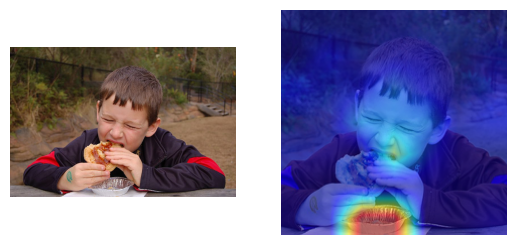

1015118661_980735411b.jpg | Score: 28.09


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a child eating ice cream


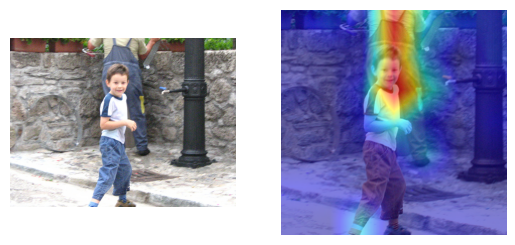

In [24]:
for fname, score in results:
    print(f"{fname} | Score: {score:.2f}")
    img_path = os.path.join(image_dir, fname)
    image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
    text_token = clip_interp.tokenize([query]).to(device)
    R_text, R_image = interpret(model=model, image=image, texts=text_token, device=device)
    show_heatmap_on_text(query, text_token[0], R_text[0])
    show_image_relevance(R_image[0], image, orig_image=Image.open(img_path))
    plt.show()

### **Conclusion**

In this study, we investigated the environmental impact of CLIP-based multimodal retrieval pipelines by systematically measuring CO₂ emissions and runtime across varying dataset sizes. By decomposing the process into encoding and retrieval stages, we observed distinct computational behaviors: the encoding step scales linearly with subset size, while the retrieval step incurs exponentially growing emissions and duration. This disparity highlights the disproportionate computational burden imposed by the retrieval phase, particularly when explanatory methods are applied, underscoring the need for more efficient and scalable search mechanisms.

Our findings emphasize the importance of integrating sustainability considerations into the design and deployment of large-scale AI systems. As vision-language models like CLIP become increasingly prevalent in downstream applications, understanding their energy profiles is essential for responsible usage. Moreover, the emission analysis presented here can guide the development of more emission-aware retrieval architectures, potentially leveraging pre-filtering, approximate nearest neighbor search, or on-device caching to reduce redundant computation.

In sum, this work provides not only a quantitative assessment of CLIP’s environmental cost but also a framework for evaluating and optimizing similar multimodal systems in an ecologically responsible manner.
